# Daten einlesen und Pipeline definieren

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score

# 1. Daten einlesen und zusammenführen
df1 = pd.read_csv('../umsatzdaten_gekuerzt.csv')
df2 = pd.read_csv('../wetter.csv')
df3 = pd.read_csv('../kiwo.csv')

df = df1.merge(df2, on='Datum', how='left')
df = df.merge(df3, on='Datum', how='left')


# Sicherstellen, dass 'Datum' als datetime konvertiert ist
df['Datum'] = pd.to_datetime(df['Datum'])

# 2. Pipeline-Komponenten definieren

# a) Feature Engineering: Erstellen von Datum- und zyklischen Features
def add_features(df):
    df = df.copy()
    # Basismerkmale
    df['Jahr'] = df['Datum'].dt.year
    df['Monat'] = df['Datum'].dt.month
    df['Wochentag'] = df['Datum'].dt.weekday
    df['Kalenderwoche'] = df['Datum'].dt.isocalendar().week
    df['Tag_im_Jahr'] = df['Datum'].dt.dayofyear
    df['Ist_Wochenende'] = df['Wochentag'].isin([5, 6]).astype(int)
    
    # Zyklische Merkmale
    df['Tag_im_Jahr_sin'] = np.sin(2 * np.pi * df['Tag_im_Jahr'] / 365)
    df['Tag_im_Jahr_cos'] = np.cos(2 * np.pi * df['Tag_im_Jahr'] / 365)
    df['Monat_sin'] = np.sin(2 * np.pi * df['Monat'] / 12)
    df['Monat_cos'] = np.cos(2 * np.pi * df['Monat'] / 12)
    df['Wochentag_sin'] = np.sin(2 * np.pi * df['Wochentag'] / 7)
    df['Wochentag_cos'] = np.cos(2 * np.pi * df['Wochentag'] / 7)
    
    # Entfernen der 'Datum'-Spalte nach der Feature-Erstellung
    df = df.drop('Datum', axis=1)
    
    return df

# b) FunctionTransformer für Feature Engineering
feature_engineering = FunctionTransformer(add_features, validate=False)

# c) Definieren der Feature-Gruppen
numeric_features = ['Temperatur', 'Bewoelkung', 'Windgeschwindigkeit',
                    'Tag_im_Jahr_sin', 'Tag_im_Jahr_cos',
                    'Monat_sin', 'Monat_cos',
                    'Wochentag_sin', 'Wochentag_cos']
                    
categorical_features = ['Warengruppe', 'Wettercode', 'Wochentag']

# d) Definieren des ColumnTransformers
# Stellen Sie sicher, dass 'Wettercode' als String vorliegt
df['Wettercode'] = df['Wettercode'].astype(str)

# Liste der Kategorien für 'Wettercode'
wettercode_categories = [str(i) for i in range(0, 100)] + ['Unbekannt']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        
        ('wettercode', OneHotEncoder(categories=[wettercode_categories], handle_unknown='ignore'), ['Wettercode']),
        
        ('warengruppe', OneHotEncoder(handle_unknown='ignore'), ['Warengruppe']),
        
        ('wochentag', OneHotEncoder(handle_unknown='ignore'), ['Wochentag'])
    ],
    remainder='drop'
)


# 3. Daten aufbereiten

# Zielvariable und Features
X = df.drop(['Umsatz'], axis=1)  # Behalten Sie 'Datum' in X für die Pipeline
y = df['Umsatz']

# Split in Trainings- und Testset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [2]:
df.head

<bound method NDFrame.head of           Datum  Warengruppe      Umsatz  Bewoelkung  Temperatur  \
0    2013-07-01            1  148.828353         6.0     17.8375   
1    2013-07-02            1  159.793757         3.0     17.3125   
2    2013-07-03            1  111.885594         7.0     21.0750   
3    2013-07-04            1  168.864941         7.0     18.8500   
4    2013-07-05            1  171.280754         5.0     19.9750   
...         ...          ...         ...         ...         ...   
9329 2017-12-21            6   87.471228         7.0      6.2375   
9330 2017-12-22            6   71.911652         7.0      5.7625   
9331 2017-12-23            6   84.062223         7.0      7.8000   
9332 2017-12-24            6   60.981969         7.0      8.1125   
9333 2017-12-27            6   34.972644         7.0      4.6125   

      Windgeschwindigkeit Wettercode  KielerWoche  
0                    15.0       20.0          NaN  
1                    10.0        nan          NaN

# Linear Regression

In [3]:
from sklearn.linear_model import LinearRegression

pipeline_1 = Pipeline(steps=[
    ('feature_engineering', feature_engineering),
    ('preprocessing', preprocessor),
    ('model',  LinearRegression())
])
pipeline_1.fit(X_train, y_train)

lr_y_pred = pipeline_1.predict(X_test)
print("R² on test:", r2_score(y_test, lr_y_pred))

R² on test: 0.7585518834097755


# RandomForestRegressor

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

pipeline = Pipeline(steps=[
    ('feature_engineering', feature_engineering),
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 4. Modell trainieren
pipeline.fit(X_train, y_train)

# 5. Vorhersagen treffen und evaluieren
y_pred = pipeline.predict(X_test)
print("R² on test:", r2_score(y_test, y_pred))

R² on test: 0.8967988393930183


# GridSearchCV

In [13]:

# 6. Hyperparameter-Tuning (optional)
param_grid = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best RF Params:", grid_search.best_params_)
y_pred_best = grid_search.predict(X_test)
print("Test R² Best RF:", r2_score(y_test, y_pred_best))

Best RF Params: {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 100}
Test R² Best RF: 0.9023886638400874


# Neuronale Netzwerk

# Performance evaluieren

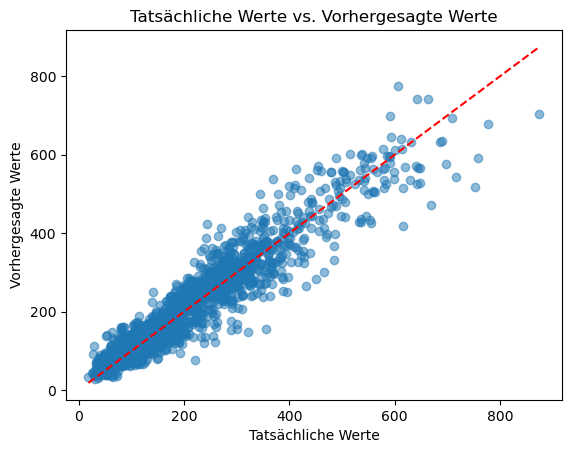

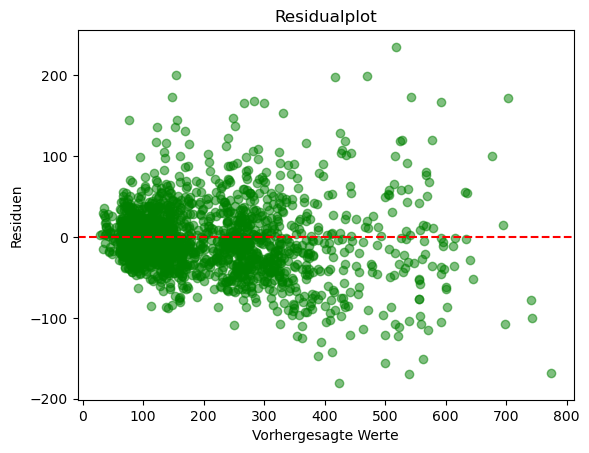

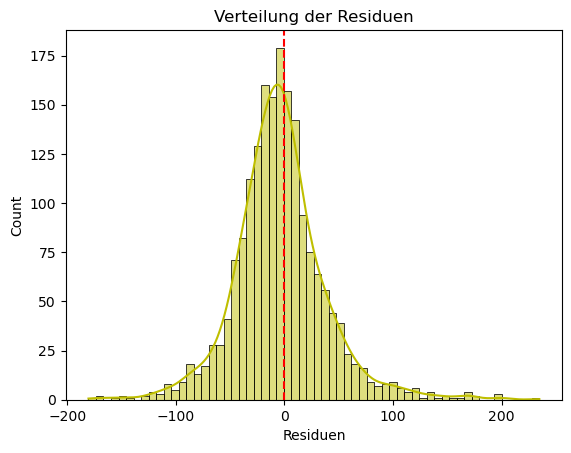

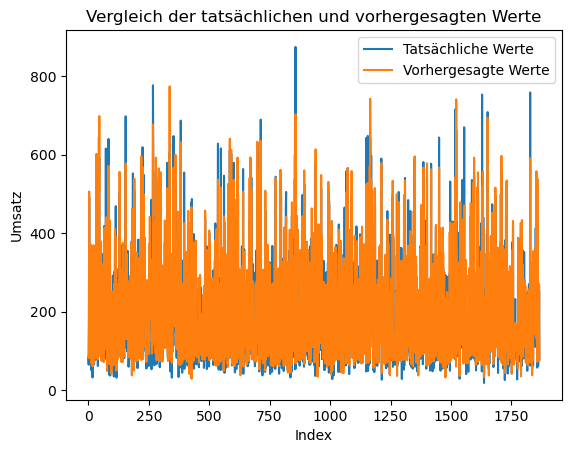

In [5]:
import matplotlib.pyplot as plt

# Scatterplot
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonale Linie
plt.xlabel("Tatsächliche Werte")
plt.ylabel("Vorhergesagte Werte")
plt.title("Tatsächliche Werte vs. Vorhergesagte Werte")
plt.show()



residuals = y_test - y_pred

# Residualplot
plt.scatter(y_pred, residuals, alpha=0.5, color='g')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Vorhergesagte Werte")
plt.ylabel("Residuen")
plt.title("Residualplot")
plt.show()


import seaborn as sns

# Histogramm der Residuen
sns.histplot(residuals, kde=True, color='y')
plt.axvline(0, color='r', linestyle='--')
plt.xlabel("Residuen")
plt.title("Verteilung der Residuen")
plt.show()


plt.plot(y_test.values, label="Tatsächliche Werte")
plt.plot(y_pred, label="Vorhergesagte Werte")
plt.legend()
plt.xlabel("Index")
plt.ylabel("Umsatz")
plt.title("Vergleich der tatsächlichen und vorhergesagten Werte")
plt.show()

# Modell auf Submission-Datensatz laufen lassen

In [ ]:
## Submission vorbereiten


df_sub = pd.read_csv('../sample_submission.csv')

# Angenommen, die Jahre sind 20xx:
df_sub['id'] = df_sub['id'].astype('string')
df_sub['Tag'] = df_sub['id'].str[0:2]
df_sub['Monat'] = df_sub['id'].str[2:4]
df_sub['Jahr'] = '20' + df_sub['id'].str[4:6]  # falls im Format YY z. B. 01 → 2001 oder 20xx

df_sub['Warengruppe'] = df_sub['id'].str[6]  # letztes Zeichen
df_sub['Warengruppe'] = df_sub['Warengruppe'].astype(int)

# Ein Datum aus Tag, Monat, Jahr erzeugen:
df_sub.rename(columns={'Jahr':'year', 'Monat':'month', 'Tag':'day'}, inplace=True)
df_sub['Datum'] = pd.to_datetime(df_sub[['year','month','day']])
df2['Datum'] = pd.to_datetime(df2['Datum'])
df3['Datum'] = pd.to_datetime(df3['Datum'])
df_sub = df_sub.merge(df3, on='Datum', how='left')
df_sub = df_sub.merge(df2, on='Datum', how='left')

df_sub['Wochentag'] = df_sub['Datum'].dt.weekday
df_sub['Ist_Wochenende'] = df_sub['Wochentag'].isin([5,6])
df_sub['Monat'] = df_sub['Datum'].dt.month
df_sub['Monat_sin'] = np.sin(2 * np.pi * df_sub['Monat']/12)
df_sub['Monat_cos'] = np.cos(2 * np.pi * df_sub['Monat']/12)

# Check if all data types are correctly set for all variables
print('### Initial datatypes')
print(df_sub.dtypes)

# Set the correct types for all variables

df_sub['Wettercode'] = df_sub['Wettercode'].astype('category')
df_sub['Warengruppe'] = df_sub['Warengruppe'].astype('category')


# replace NaN with False for 'KielerWoche'
df_sub['KielerWoche'] = df_sub['KielerWoche'].fillna(False)
df_sub['KielerWoche'] = df_sub['KielerWoche'].astype('bool')
print('### Corrected datatypes')
print(df_sub.dtypes)


# Datum in Datetime konvertieren
df_sub['Datum'] = pd.to_datetime(df_sub['Datum'])

# Basismerkmale
df_sub['Jahr'] = df_sub['Datum'].dt.year
df_sub['Monat'] = df_sub['Datum'].dt.month
df_sub['Wochentag'] = df_sub['Datum'].dt.weekday
df_sub['Kalenderwoche'] = df_sub['Datum'].dt.isocalendar().week
df_sub['Tag_im_Jahr'] = df_sub['Datum'].dt.dayofyear
df_sub['Tag_im_Jahr_sin'] = np.sin(2 * np.pi * df_sub['Tag_im_Jahr'] / 365)
df_sub['Tag_im_Jahr_cos'] = np.cos(2 * np.pi * df_sub['Tag_im_Jahr'] / 365)
df_sub['Ist_Wochenende'] = df_sub['Wochentag'].isin([5, 6]).astype(int)


# Zyklische Merkmale
df_sub['Monat_sin'] = np.sin(2 * np.pi * df_sub['Monat'] / 12)
df_sub['Monat_cos'] = np.cos(2 * np.pi * df_sub['Monat'] / 12)
df_sub['Wochentag_sin'] = np.sin(2 * np.pi * df_sub['Wochentag'] / 7)
df_sub['Wochentag_cos'] = np.cos(2 * np.pi * df_sub['Wochentag'] / 7)


# Beispiel für Mittelwert-Imputation
df_sub['Temperatur'].fillna(df_sub['Temperatur'].mean(), inplace=True)
df_sub['Bewoelkung'].fillna(df_sub['Bewoelkung'].mean(), inplace=True)
df_sub['Windgeschwindigkeit'].fillna(df_sub['Windgeschwindigkeit'].mean(), inplace=True)

df_sub['Wettercode'] = df_sub['Wettercode'].cat.add_categories(['Unbekannt'])
df_sub['Wettercode'] = df_sub['Wettercode'].fillna('Unbekannt')


# Sicherstellen, dass 'Datum' als datetime konvertiert ist
df['Datum'] = pd.to_datetime(df['Datum'])



# 5. Vorhersagen treffen und evaluieren
y_pred_sub = pipeline.predict(df_sub)
y_pred_sub_best = grid_search.predict(df_sub)

df_sub['Umsatz'] = y_pred_sub_best

# Erstellen der finalen Submission:
df_sub[['id','Umsatz']].to_csv('../submission.csv', index=False)

### Initial datatypes
id                             string
Umsatz                          int64
day                            string
month                          string
year                           string
Warengruppe                     int64
Datum                  datetime64[ns]
KielerWoche                   float64
Bewoelkung                    float64
Temperatur                    float64
Windgeschwindigkeit           float64
Wettercode                    float64
Wochentag                       int64
Ist_Wochenende                   bool
Monat                           int64
Monat_sin                     float64
Monat_cos                     float64
dtype: object
### Corrected datatypes
id                             string
Umsatz                          int64
day                            string
month                          string
year                           string
Warengruppe                  category
Datum                  datetime64[ns]
KielerWoche                 